In [1]:
import os

download_name = "worldcities_with_splits.csv.zip"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a03/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()
        
name = "worldcities_with_splits.csv"
if not os.path.exists(name):
    from zipfile import ZipFile
    with ZipFile(download_name) as zf:
        zf.extract(name)

del download_name, name   

# SOLUTION: Classifying Cities with a Multilayer Perceptron

## Imports

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


from nlp import StepByStep, ConvVectorizer, Vocabulary
from itertools import chain

## Vocabulary

👍
Create variables:
* `country_vocab` as instance of `Vocabulary` filled with cities from `train_df`
* `city_vocab` as instance of `Vocabulary` whose unknown token is `@` and is filled with all letters from all cities in `train_df`

In [23]:
city_df = pd.read_csv("worldcities_with_splits.csv")

train_df = city_df[city_df.split == "train"]
val_df = city_df[city_df.split == "val"]
test_df = city_df[city_df.split == "test"]

# vocab
country_vocab = Vocabulary()
country_vocab.fill(train_df.country)

city_vocab = Vocabulary(unk_tok="@")
city_vocab.fill(chain(*train_df.city))

assert len(country_vocab) == 80
assert len(city_vocab) == 199

assert country_vocab == {'Albania': 0, 'Algeria': 1, 'Angola': 2, 'Argentina': 3, 'Armenia': 4, 'Australia': 5, 'Austria': 6, 'Azerbaijan': 7, 'Belarus': 8, 'Belgium': 9, 'Bolivia': 10, 'Brazil': 11, 'Bulgaria': 12, 'Canada': 13, 'Chile': 14, 'China': 15, 'Colombia': 16, 'Congo (Kinshasa)': 17, 'Croatia': 18, 'Cuba': 19, 'Czechia': 20, 'Dominican Republic': 21, 'Ecuador': 22, 'Egypt': 23, 'El Salvador': 24, 'Finland': 25, 'France': 26, 'Germany': 27, 'Greece': 28, 'Guatemala': 29, 'Hungary': 30, 'India': 31, 'Indonesia': 32, 'Iran': 33, 'Israel': 34, 'Italy': 35, 'Japan': 36, 'Kazakhstan': 37, 'Kenya': 38, 'Lithuania': 39, 'Macedonia': 40, 'Malta': 41, 'Mexico': 42, 'Moldova': 43, 'Morocco': 44, 'Netherlands': 45, 'New Zealand': 46, 'Nicaragua': 47, 'Niger': 48, 'Nigeria': 49, 'Norway': 50, 'Pakistan': 51, 'Peru': 52, 'Philippines': 53, 'Poland': 54, 'Portugal': 55, 'Puerto Rico': 56, 'Romania': 57, 'Russia': 58, 'Serbia': 59, 'Slovakia': 60, 'Slovenia': 61, 'South Africa': 62, 'South Korea': 63, 'Spain': 64, 'Sweden': 65, 'Switzerland': 66, 'Syria': 67, 'Tanzania': 68, 'Thailand': 69, 'Tunisia': 70, 'Turkey': 71, 'Uganda': 72, 'Ukraine': 73, 'United Kingdom': 74, 'United States': 75, 'Uruguay': 76, 'Uzbekistan': 77, 'Venezuela': 78, 'Vietnam': 79}
assert "".join(city_vocab) == "@ '()-./34ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz·ÀÁÄÅÇÉÍÎÓÖØÚÜßàáâãäåçèéêëìíîïñòóôõöøùúûüýĀāăąĆćċČčďĐđēėęěğĠġĦħĩĪīİıĽľŁłńňŌōŏőœřŚśŞşŠšŢţťũūŬŭůųźŻżŽžƏơưə̧̄ḐḑḨḩḯṬṭẔẕẖạảẤầẩắằẵếệịốồộợủứỳỹ‘’"


True

## Vectorization

👍
Create variable `city_vectorizer` as instance of `ConvVectorizer` whose vocabulary is `city_vocab` and maximal size is the longest city name from `train_df` dataframe.

In [28]:
# vectorizer
city_vectorizer = ConvVectorizer(city_vocab, max_size=max(train_df.city.apply(len)))

assert city_vectorizer.vectorize("split").shape == (199, 38)
assert city_vectorizer.vectorize("split").nonzero().tolist() == [[44, 3], [47, 2], [51, 1], [54, 0], [55, 4]]

## Splitted vectorized datasets

In [ ]:

x_train = city_vectorizer.vectorize_many(train_df.city)
y_train = country_vocab.vocabularize(train_df.country)

x_val = city_vectorizer.vectorize_many(val_df.city)
y_val = country_vocab.vocabularize(val_df.country)

x_test = city_vectorizer.vectorize_many(test_df.city)
y_test = country_vocab.vocabularize(test_df.country)

## Class Weights

👍
Create variable `class_counts` as dictionary whose keys are countries and values are frequencies of countries in `train_df` dataframe.
Order counts by order of their appearance in `country_vocab` vocabulary.

Create variable `y_weight_tensor` whose value is 
$$ \frac{1}{log(freq(country))} $$
where $ freq(country) $ is frequency of country in `train_df` dataframe.

Order weights by order of their appearance in `country_vocab` vocabulary.

In [36]:
class_counts = train_df.country.value_counts().to_dict()
class_counts = {cls: class_counts[cls] 
                for cls in sorted(class_counts, key=country_vocab.get)}

y_freq_tensor = torch.zeros(len(class_counts))
for cls, cnt in class_counts.items():
    i = country_vocab[cls]
    y_freq_tensor[i] = cnt


y_weight_tensor = 1 / torch.log(y_freq_tensor)

y_weight_tensor

assert y_weight_tensor.shape == (80,)
assert torch.allclose(y_weight_tensor[:5], torch.tensor([0.2813, 0.2132, 0.2396, 0.1849, 0.2749]), atol=1e-4)

## Plotting frequencies and weights

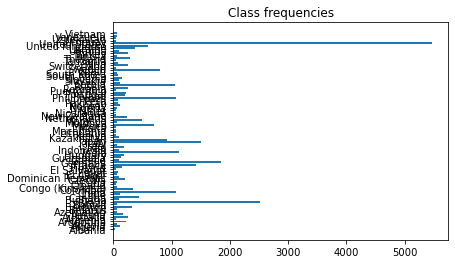

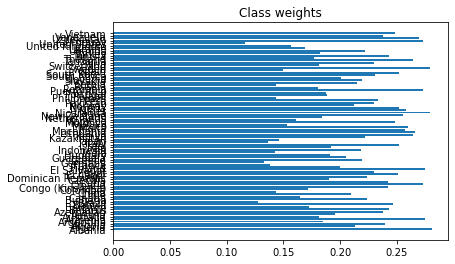

In [30]:
plt.title("Class frequencies")
plt.barh(list(class_counts), y_freq_tensor)
plt.show()

plt.title("Class weights")
plt.barh(list(class_counts), y_weight_tensor)
plt.show()


## Dataset

In [40]:
class CityDataset(Dataset):

    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

## The Model: CityClassifier

👍 Create `CityClassifier` class as MLP with single hidden layer. Methods are:
* `__init__(self, in_channel, in_dim, conv_channels, conv_kernel_sizes, conv_strides, conv_activation, out_dim)` initializes perceptron with
* input channel (the first input channel size - row number of one-hot matrix)
* input dimension (column number of one-hot matrix)
* list of 1D convolution output/input channels, kernel sizes and strides, 
* convolution activation function.
* output dimension (should be the number of output classes)

For example, 
`__init__(in_channel=10, in_dim=15, conv_channels=[16, 32, 64], conv_kernel_sizes=[2, 3, 2], conv_strides=[1, 2, 1], conv_activation, out_dim=6)`
will create three 1D convolution layers with activations after each:
* conv1 with 10 input channels (in_channel argument), 16 output channels, kernel size 2, stride 1 following by activation,
* conv2 with 16 input channels, 32 output channels, kernel size 3, stride 2 followed by activation,
* conv3 with 32 input channels, 64 output channels, kernel size 2, stride 1 (outputs feature vector) followed by activation.

and single fully connected layer fc:
* with input size X (size of flattened output features vector from the last convolutional layer, must be computed by applying convolutions on `in_dim`)
* and output size 6 (this is the number of output classes)


* `forward(self, x_in, apply_softmax=False)` for given input `x_in` makes forward step and eventually applies softmax on output. 

In [39]:
class CityClassifier(nn.Module):

    def __init__(self, in_channel, in_dim, conv_channels, conv_kernel_sizes, conv_strides, conv_activation, out_dim):
        super(CityClassifier, self).__init__()   

        assert len(conv_channels) == len(conv_kernel_sizes) == len(conv_strides)

        feature_dim = in_dim
        seq = []
        prev_num_channels = in_channel
        for num_channels, kernel_size, stride in zip(conv_channels, conv_kernel_sizes, conv_strides):
            seq.append(nn.Conv1d(in_channels=prev_num_channels, 
                                 out_channels=num_channels, 
                                 kernel_size=kernel_size, 
                                 stride=stride))
            seq.append(conv_activation())
            
            feature_dim = (feature_dim - kernel_size) // stride + 1
            prev_num_channels = num_channels

        self.convnet = nn.Sequential(*seq)
        
        feature_dim *= prev_num_channels
        self.fc = nn.Linear(in_features=feature_dim, out_features=out_dim)

    def forward(self, x_in, apply_softmax=False):
        features = self.convnet(x_in).flatten(start_dim=1)
        prediction_vector = self.fc(features)
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)
        return prediction_vector


StepByStep.set_seed(96)        
model = CityClassifier(10, 15, [16, 32, 64], [2, 3, 2], [1, 2, 1], nn.ReLU, 6)
x_in = torch.rand(size=(2,10,15))
model(x_in)

assert torch.allclose(model(x_in), torch.tensor([[-0.0039,  0.0378,  0.0248,  0.0332, -0.0369, -0.0778],
                                                 [ 0.0006,  0.0397,  0.0128,  0.0444, -0.0118, -0.0676]]), atol=1e-4)
del model, x_in


## Train

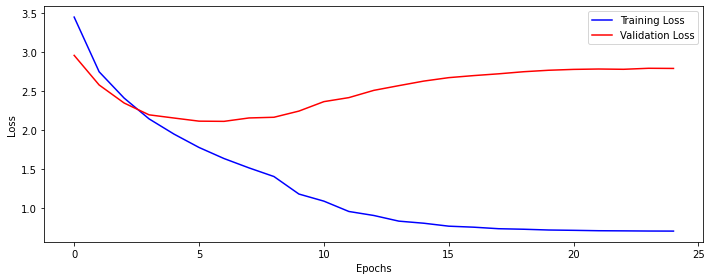

In [15]:
StepByStep.set_seed(96)

model = CityClassifier(in_channel=len(city_vocab), 
                       in_dim=city_vectorizer.max_size, 
                       conv_channels=[256, 256, 256, 256], 
                       conv_kernel_sizes=[3, 3, 3, 3], 
                       conv_strides=[1, 2, 2, 1], 
                       conv_activation=nn.ReLU,
                       out_dim=len(country_vocab))


loss_fn = nn.CrossEntropyLoss(weight=y_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_loader = DataLoader(CityDataset(x_train, y_train), batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(CityDataset(x_val, y_val), batch_size=64, drop_last=True, shuffle=True)

sbs = StepByStep(model, loss_fn, optimizer, scheduler)
sbs.set_loaders(train_loader, val_loader)

sbs.train_by_loss_change(1e-3)

sbs.plot_losses(ylog=False)


## Accuracy

In [9]:
# accuracy
(sbs.predict(x_test).argmax(dim=1) == y_test).sum() / y_test.shape[0]

Expanded filepaths: 
	./vectorizer.json
	./model.pth
Using CUDA: False


## Test

In [10]:
y_pred = sbs.model(x_test, apply_softmax=True).argmax(dim=1)

labels = list(country_vocab)

confusion = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(confusion, index=labels, columns=labels)
#conf_df[conf_df==0] = ""

sns.heatmap(conf_df, annot=True, cbar=None, cmap="GnBu", fmt="d")
plt.tight_layout()
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()
#confusion_matrix(y_test, y_pred)

Creating fresh!


CityClassifier(
  (convnet): Sequential(
    (0): Conv1d(199, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (3): ReLU()
    (4): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (5): ReLU()
    (6): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (7): ReLU()
  )
  (fc): Linear(in_features=1536, out_features=80, bias=True)
)

## Inference

In [11]:
def predict_country(city, model, city_vectorizer, country_vocab):
    x = city_vectorizer.vectorize(city).unsqueeze(dim=0)
    y_pred = model(x, apply_softmax=True)
    i = y_pred.argmax(dim=1).item()
    country = country_vocab.inv[i]
    return country

predict_country("Split", sbs.model, city_vectorizer, country_vocab)

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/442 [00:00<?, ?it/s]

split=val:   0%|          | 0/94 [00:00<?, ?it/s]

Exiting loop


## Top-K inference

In [12]:
def predict_topk_country(city, model, city_vectorizer, country_vocab, k=5):
    x = city_vectorizer.vectorize(city).unsqueeze(dim=0)
    y_pred = model(x, apply_softmax=True)

    probs, indices = torch.topk(y_pred, k=k)
    probs = probs.squeeze().tolist()
    indices = indices.squeeze().tolist()

    nationalities = {}
    print(f"Top {k} predictions:")
    for i, p in zip(indices, probs):
        country = country_vocab.inv[i]
        nationalities[country] = p
        print(f"{city} => {country} (p={p:.3f})")

    return nationalities

predict_topk_country("Jarofski", sbs.model, city_vectorizer, country_vocab, k=5)

# Visualization

👍 for some city, plot its vectorization using heatmap. One dimension should have city letters ticks.

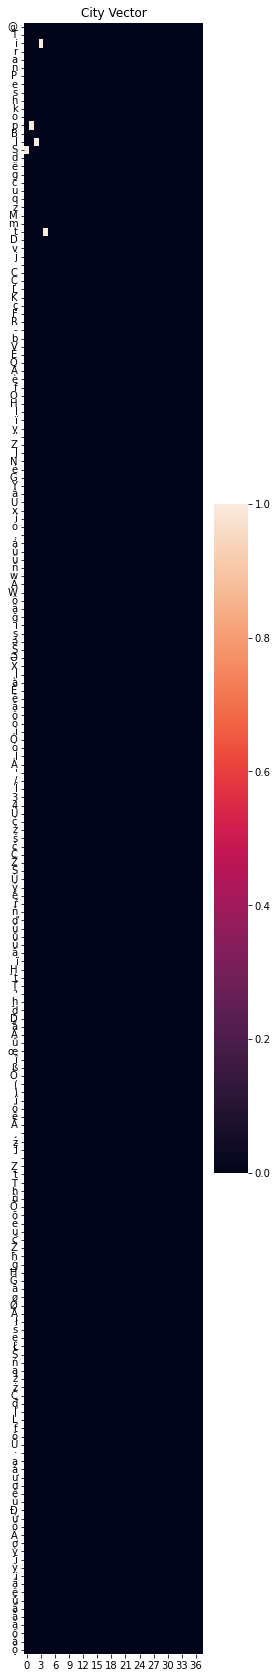

In [32]:


vectorized_city = city_vectorizer.vectorize("Split")
vectorized_city = torch.tensor(vectorized_city).unsqueeze(0)

plt.figure(figsize=(4, 30))
plt.title("City Vector")
sns.heatmap(vectorized_city.squeeze(0), yticklabels=city_vocab)
plt.show()

👍 pass vectorized city through all classifier's convolutional layers and plot their vectorization using heatmap. The last vector is feature vector.

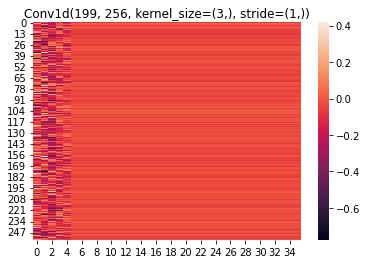

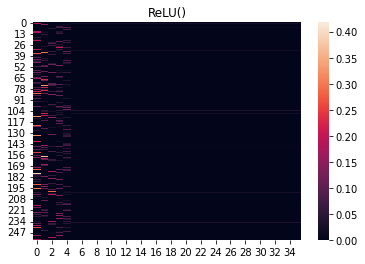

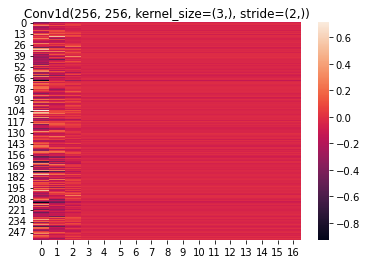

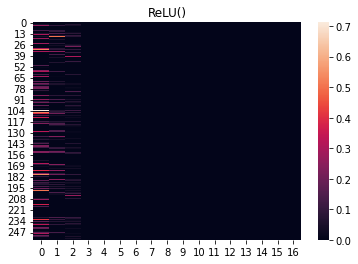

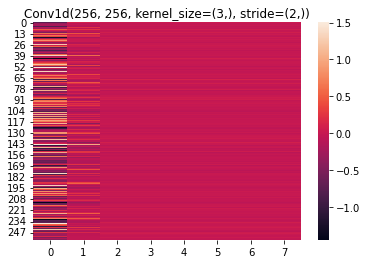

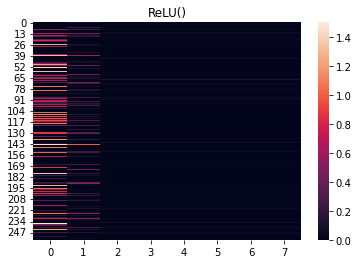

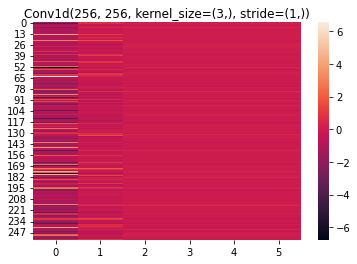

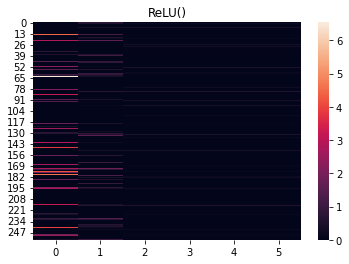

In [33]:
interim_vec = vectorized_city

for model in model.convnet:
    interim_vec = model(interim_vec)
    plt.title(str(model))
    sns.heatmap(interim_vec.squeeze(0).detach())
    plt.show()

👍 pass feature vector through classifier's fully connected layer and plot their vectorization using heatmap. One dimension should have country ticks. 

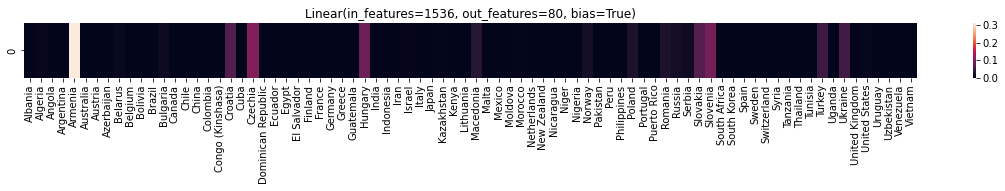

In [57]:
out_vec = F.softmax(model.fc(interim_vec.flatten(start_dim=1)), dim=1)

plt.figure(figsize=(20, 1))
plt.title(str(model.fc))
sns.heatmap(out_vec.detach(), xticklabels=country_vocab)
plt.show()